In [1]:

import numpy as np
from sympy import *

#--- Model Parameters ---
d       = symbols('d',    real=True, positive=True)         # Distance between wheels
visc    = symbols('c_alpha',real=True)                      # Viscous, damping constant 
l       = symbols('l',    real=True, positive=True)         # Height of the COM
r       = symbols('r',    real=True, positive=True)         # Radius of the wheel
Mp      = symbols('M_p',  real=True, positive=True)         # Mass of the pendulum without the wheels
Mw      = symbols('M_w',  real=True, positive=True)         # Mass of each wheel
Iw_c    = symbols('I_wc',  real=True)                       # MOI wheel center
Iw_r    = symbols('I_wr',  real=True)                       # MOI wheel radial
Ip_x    = symbols('I_px',  real=True)                       # MOI pendulum x
Ip_y    = symbols('I_py',  real=True)                       # MOI pendulum y
Ip_z    = symbols('I_pz',  real=True)                       # MOI pendulum z

#--- Constants & Aux. variables ---
g = symbols('g', constant=True)                             # Gravity acceleration
t = symbols('t', real=True)                                 # Time

#--- State Variables ---
x           = symbols('x',  real=True)                      # Linear pos
pitch       = symbols('theta',  real=True)                  # Pitch angle
yaw         = symbols('psi',  real=True)                    # Yaw angle
x_vel       = Derivative(x,t)                               # Linear vel
pitch_vel   = Derivative(pitch,t)                           # Pitch vel
yaw_vel     = Derivative(yaw,t)                             # Yaw vel
x_acc       = Derivative(x_vel,t)                           # Linear acc
pitch_acc   = Derivative(pitch_vel,t)                       # Pitch acc
yaw_acc     = Derivative(yaw_vel,t)                         # Yaw acc

#--- Inputs ---
Tl = symbols('T_L', real=True)                              # Torque of the left wheel
Tr = symbols('T_R', real=True)                              # Torque of the right wheel

## Defining all the matrices of the system
----------

In [2]:

#*--- Matrices for the 3 states model
M = Matrix([[Mp+2*Mw+2*Iw_c/r**2, Mp*l*cos(pitch) ,                                                                     0],
            [ Mp*l*cos(pitch)   , Ip_y+Mp*l**2    ,                                                                     0],
            [0                  ,                0, Ip_z+2*Iw_r+(Mw+Iw_c/r**2)*d**2/2-(Ip_z-Ip_x-Mp*l**2)*sin(pitch)**2  ]])

C = Matrix([[                      0, -Mp*l*pitch_vel*sin(pitch),                          -Mp*l*yaw_vel*sin(pitch)],
            [                      0,                          0, (Ip_z-Ip_x-Mp*l**2)*yaw_vel*sin(pitch)*cos(pitch)],
            [Mp*l*yaw_vel*sin(pitch), -(Ip_z-Ip_x-Mp*l**2)*yaw_vel*sin(pitch)*cos(pitch), -(Ip_z-Ip_x-Mp*l**2)*pitch_vel*sin(pitch)*cos(pitch)]])

D = Matrix([[2*visc/r**2, -2*visc/r, 0],
            [-2*visc/r, 2*visc, 0],
            [0, 0, (d**2/(2*r**2))*visc]])

B = Matrix([[     1/r,     1/r],
            [      -1,      -1],
            [-d/(2*r), d/(2*r)]])

G = Matrix([[0],[-Mp*l*g*sin(pitch)], [0]])

q = Matrix([[x],[pitch],[yaw]])

q_diff = Matrix([[x_vel],[pitch_vel],[yaw_vel]])

q_2diff = Matrix([[x_acc],[pitch_acc],[yaw_acc]])

u = Matrix([[Tl],[Tr]])

In [3]:
M_inv = M.inv()

## Show system in expression form
---

In [4]:
# eqt_sys = M*q_2diff + (C+D)*q_diff + G - B*u
# eqt_sys
expr_model = M_inv*((B*u-G)-(C+D)*q_diff)
eqts_model = Eq(q_2diff,expr_model)
eqts_model

Eq(Matrix([
[    Derivative(x, (t, 2))],
[Derivative(theta, (t, 2))],
[  Derivative(psi, (t, 2))]]), Matrix([
[          -M_p*l*(M_p*g*l*sin(theta) - T_L - T_R - 2*c_alpha*Derivative(theta, t) + 2*c_alpha*Derivative(x, t)/r - (-I_px + I_pz - M_p*l**2)*sin(theta)*cos(theta)*Derivative(psi, t)**2)*cos(theta)/(-M_p**2*l**2*cos(theta)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (I_py + M_p*l**2)*(M_p*l*sin(theta)*Derivative(psi, t)**2 + T_L/r + T_R/r - 2*c_alpha*Derivative(x, t)/r**2 - (-M_p*l*sin(theta)*Derivative(theta, t) - 2*c_alpha/r)*Derivative(theta, t))/(-M_p**2*l**2*cos(theta)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))],
[-M_p*l*(M_p*l*sin(theta)*Derivative(psi, t)**2 + T_L/r + T_R/r - 2*c_alpha*Derivative(x, t)/r**2 - (-M_p*l*sin(theta)*Derivative(theta, t) - 2*c_alpha/r)*Derivative(theta, t))*cos(theta)/(-M_p**2*l**2*cos(theta)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (2*I_wc/r**2 + M_p + 2*M_w)*(M_p*g*l*sin(theta) - T_L - T_R - 2*c_alpha*Derivati

## Linearization of the system
----------

In [306]:

#* Convert real variables into state-space variables

# Build state vector
real_state_vec = q_diff.row_insert(4,q)
state_vec = Matrix(list(symbols('x1:7',real=True)))
state_eq = Eq(state_vec,real_state_vec)
state_eq

Eq(Matrix([
[x1],
[x2],
[x3],
[x4],
[x5],
[x6]]), Matrix([
[    Derivative(x, t)],
[Derivative(theta, t)],
[  Derivative(psi, t)],
[                   x],
[               theta],
[                 psi]]))

In [317]:

#* Build the derivative of the state vector

real_state_diff_vec = q_2diff.row_insert(4,q_diff)
state_diff_vec = []
for sym in state_vec:
    state_diff_vec.append(Derivative(sym,t))
state_diff_vec = Matrix(state_diff_vec)
state_diff_eq = Eq(state_diff_vec,real_state_diff_vec)

#* Build the vector of system equations

system_equations = expr_model.row_insert(4,q_diff)

#* Substitute the real variables with the state-stape model variables: x1:x6

for i in range(6):
        system_equations = system_equations.subs(real_state_vec[i],state_vec[i])

#* Show the system of equations that will be used in the state space form 

eq_sys = Eq(state_diff_vec,system_equations)
eq_sys

Eq(Matrix([
[Derivative(x1, t)],
[Derivative(x2, t)],
[Derivative(x3, t)],
[Derivative(x4, t)],
[Derivative(x5, t)],
[Derivative(x6, t)]]), Matrix([
[          -M_p*l*(M_p*g*l*sin(x5) - T_L - T_R - 2*c_alpha*x2 + 2*c_alpha*x1/r - x3**2*(-I_px + I_pz - M_p*l**2)*sin(x5)*cos(x5))*cos(x5)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (I_py + M_p*l**2)*(M_p*l*x3**2*sin(x5) + T_L/r + T_R/r - 2*c_alpha*x1/r**2 - x2*(-M_p*l*x2*sin(x5) - 2*c_alpha/r))/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))],
[-M_p*l*(M_p*l*x3**2*sin(x5) + T_L/r + T_R/r - 2*c_alpha*x1/r**2 - x2*(-M_p*l*x2*sin(x5) - 2*c_alpha/r))*cos(x5)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (2*I_wc/r**2 + M_p + 2*M_w)*(M_p*g*l*sin(x5) - T_L - T_R - 2*c_alpha*x2 + 2*c_alpha*x1/r - x3**2*(-I_px + I_pz - M_p*l**2)*sin(x5)*cos(x5))/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))],
[                                        

In [318]:

#* Calcualte the jacobian for the A matrix of the continuos time system
Ac = Matrix(np.zeros((6,6)))

for i,expr in enumerate(system_equations):
    for j,state in enumerate(state_vec):
        Ac[i,j] = diff(expr,state)
Ac

Matrix([
[         -2*M_p*c_alpha*l*cos(x5)/(r*(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))) - 2*c_alpha*(I_py + M_p*l**2)/(r**2*(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))),            2*M_p*c_alpha*l*cos(x5)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (I_py + M_p*l**2)*(2*M_p*l*x2*sin(x5) + 2*c_alpha/r)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)),                 2*M_p*l*x3*(I_py + M_p*l**2)*sin(x5)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + 2*M_p*l*x3*(-I_px + I_pz - M_p*l**2)*sin(x5)*cos(x5)**2/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)), 0,      2*M_p**3*l**3*(M_p*g*l*sin(x5) - T_L - T_R - 2*c_alpha*x2 + 2*c_alpha*x1/r - x3**2*(-I_px + I_pz - M_p*l**2)*sin(x5)*cos(x5))*sin(x5)*cos(x5)**2/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))**2 - 2*M_p**2*l**2*(I_py + M_p*l**2)*(M_

In [319]:

#* Calcualte the jacobian for the B matrix of the continuos time system
Bc = Matrix(np.zeros((6,2)))

for i,expr in enumerate(system_equations):
    for j,torque in enumerate(u):
        Bc[i,j] = diff(expr,torque)
# Bc

Matrix([
[           M_p*l*cos(x5)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (I_py + M_p*l**2)/(r*(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))),            M_p*l*cos(x5)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (I_py + M_p*l**2)/(r*(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)))],
[-M_p*l*cos(x5)/(r*(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))) - (2*I_wc/r**2 + M_p + 2*M_w)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)), -M_p*l*cos(x5)/(r*(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))) - (2*I_wc/r**2 + M_p + 2*M_w)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))],
[                                                                                                          -d/(2*r*(I_pz + 2*I_wr + d**2*(I_wc/r**2 + M_w)/2 - (-I_px + I_pz - M_p*l**2)*sin(x5)**2

In [322]:

#* Evaluate Ac at the fixed points

fixed_point = [0,0,0,0,0,0] # Values for dx/dt
input_fixed_points = [0,0]

Ac_eval = Ac.subs([(state_vec[0], fixed_point[0]),
                   (state_vec[1], fixed_point[1]),
                   (state_vec[2], fixed_point[2]),
                   (state_vec[3], fixed_point[3]),
                   (state_vec[4], fixed_point[4]),
                   (state_vec[5], fixed_point[5]),
                   (Tl,input_fixed_points[0]),
                   (Tr,input_fixed_points[1])])

# Ac_eval


In [324]:

#* Evaluate Bc at the fixed points

Bc_eval = Bc.subs([(state_vec[0], fixed_point[0]),
                   (state_vec[1], fixed_point[1]),
                   (state_vec[2], fixed_point[2]),
                   (state_vec[3], fixed_point[3]),
                   (state_vec[4], fixed_point[4]),
                   (state_vec[5], fixed_point[5]),
                   (Tl,input_fixed_points[0]),
                   (Tr,input_fixed_points[1])])

# Bc_eval

In [331]:


# Define the values of each Model Parameter

d_v    = (d,    0.1431)
visc_v = (visc, 0.01)
r_v    = (r,    0.05)
Mp_v   = (Mp,   2.036)
Mw_v   = (Mw,   0.268)
Iw_c_v = (Iw_c, 0.00033613)
Iw_r_v = (Iw_r, 0.00018876)
g_v = (g, 9.81)

#-- Pose A ---
l_v    = (l,   0.1806)
Ip_x_v = (Ip_x, 0.02500992)
Ip_y_v = (Ip_y, 0.02255237)
Ip_z_v = (Ip_z, 0.00546422)


In [338]:

#* Plug in the Model parameters values 

Ac_lin = Ac_eval.subs([d_v,visc_v,l_v,r_v,Mp_v,Mw_v,Iw_c_v,Iw_r_v,Ip_x_v,Ip_y_v,Ip_z_v,g_v])
Bc_lin = Bc_eval.subs([d_v,visc_v,l_v,r_v,Mp_v,Mw_v,Iw_c_v,Iw_r_v,Ip_x_v,Ip_y_v,Ip_z_v,g_v])

## Discretization of the system (TODO)
---

In [341]:
Ts = 0.01 # 100 hz


## Control analisis
---

In [347]:
import control
import matplotlib.pyplot as plt

ctrb_m = control.ctrb(Ac_lin,Bc_lin)
np.linalg.matrix_rank(ctrb_m)

6

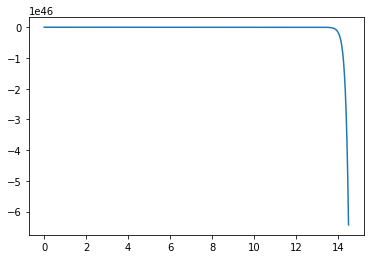

In [353]:
C_ss = np.array([1, 1, 1, 1, 1, 1])
D_ss = np.array([0,0])

ss_system = control.ss(Ac_lin,Bc_lin)

# t, y = control.step_response(ss_system)

# plt.plot(t,y[0,0,:])


## View all matrices
----

In [67]:
M

Matrix([
[2*I_wc/r**2 + M_p + 2*M_w, M_p*l*cos(theta),                                                                                  0],
[         M_p*l*cos(theta),  I_py + M_p*l**2,                                                                                  0],
[                        0,                0, I_pz + 2*I_wr + d**2*(I_wc/r**2 + M_w)/2 - (-I_px + I_pz - M_p*l**2)*sin(theta)**2]])

In [72]:
C

Matrix([
[                                    0,                          -M_p*l*sin(theta)*Derivative(theta, theta),                                  -M_p*l*sin(theta)*Derivative(psi, psi)],
[                                    0,                                                                   0,    (-I_px + I_pz - M_p*l**2)*sin(theta)*cos(theta)*Derivative(psi, psi)],
[M_p*l*sin(theta)*Derivative(psi, psi), (I_px - I_pz + M_p*l**2)*sin(theta)*cos(theta)*Derivative(psi, psi), (I_px - I_pz + M_p*l**2)*sin(theta)*cos(theta)*Derivative(theta, theta)]])

In [68]:
D

Matrix([
[2*c_alpha/r**2, -2*c_alpha/r,                     0],
[  -2*c_alpha/r,    2*c_alpha,                     0],
[             0,            0, c_alpha*d**2/(2*r**2)]])

In [69]:
B

Matrix([
[     1/r,     1/r],
[      -1,      -1],
[-d/(2*r), d/(2*r)]])

In [70]:
G

Matrix([
[                  0],
[-M_p*g*l*sin(theta)],
[                  0]])

In [71]:
u

Matrix([
[T_L],
[T_R]])

In [280]:
f = symbols('f', constant=True)
f


f